# Relax Challenge
Scott Atkinson

## [0. Contents](#0.)<a id='0.'></a>

## [1. Import libraries and data](#1.)

## [2. Feature engineering and EDA](#2.)

## [3. VIF analysis for feature importance](#3.)

## 1. Import libraries and data<a id='1.'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

from datetime import timedelta

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve
from sklearn.pipeline import Pipeline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

plt.rcParams['figure.figsize'] = (10,10)

In [2]:
us = pd.read_csv('takehome_users.csv', encoding='latin-1')

# pass last_session_creation_time to datetime and convert missing values to utc 0
us['last_session_creation_time'] = pd.to_datetime(us['last_session_creation_time'].apply(lambda C: 0 if C!=C else C)*(10**9))

# pass creation_time to datetime
us['creation_time'] = pd.to_datetime(us['creation_time'])
# convert missing invited_by_user_id entries to 0 and pass variable to integer datatype
us['invited_by_user_id'] = us['invited_by_user_id'].apply(lambda C: 0 if C!=C else C).apply(int)


en = pd.read_csv('takehome_user_engagement.csv')

# pass time_stamp column to datetime
en['time_stamp'] = pd.to_datetime(en['time_stamp'])

In [3]:
us.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240


In [4]:
en.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## 2. Feature Engineering and EDA<a id='2.'></a>

In [5]:
# function that returns True if user logged in on three separate occasions within a 7-day period

def adopted(user_id):
    login_list = list(en[en['user_id'] == user_id].sort_values('time_stamp')['time_stamp'])
    for i in range(len(login_list) - 3):
        if login_list[i+2] - login_list[i] <= timedelta(weeks=1):
            return True
    return False

# create label column 'adopted'

us['adopted'] = us['object_id'].apply(adopted)

In [6]:
# create creation_to_last column giving the amount of time between creation_time and 
# last_session_creation_time

us['creation_to_last'] = 0

for i in us.index:
    last = us.loc[i,'last_session_creation_time']
    if last == pd.to_datetime('1970-01-01 00:00:00'):
        us.loc[i,'creation_to_last'] = 0
    else:
        us.loc[i,'creation_to_last'] = (last - us.loc[i,'creation_time']).days

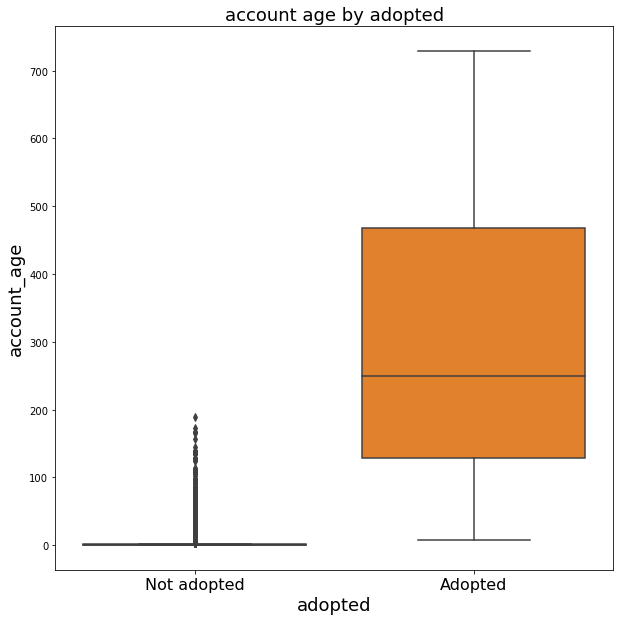

In [7]:

sns.boxplot(x='adopted', y='creation_to_last', data=us)
#plt.ylim([0,23])
plt.xlabel('adopted',fontsize=18)
plt.ylabel('account_age', fontsize=18)
plt.title('account age by adopted',fontsize=18)
plt.xticks(ticks=[0,1],labels=['Not adopted','Adopted'],fontsize=16)
#plt.yticks(ticks=[5,10,15,20],labels=[5,10,15,20],fontsize=16)
plt.show()


Time between creation and last login seems to indicate product adoption.  This, however, is data leakage since we would like to predict adoption when a user signs up.

In [8]:
# function that returns the total number of visits by a user

def visits(user_id):
    return en[en['user_id']==user_id]['visited'].sum()

# create 'visits' column

us['visits'] = us['object_id'].apply(visits)

In [9]:
# create 'visits_per_day' column

us['visits_per_day'] = 0

for i in us.index:
    v = us.loc[i,'visits']
    first = us.loc[i,'creation_time']
    last = us.loc[i,'last_session_creation_time']
    days = ((last - first).days)
    if last == pd.to_datetime('1970-01-01 00:00:00'):
        us.loc[i,'visits_per_day'] = 0
    elif days == 0:
        us.loc[i,'visits_per_day'] = v
    else:
        us.loc[i,'visits_per_day'] = v/days

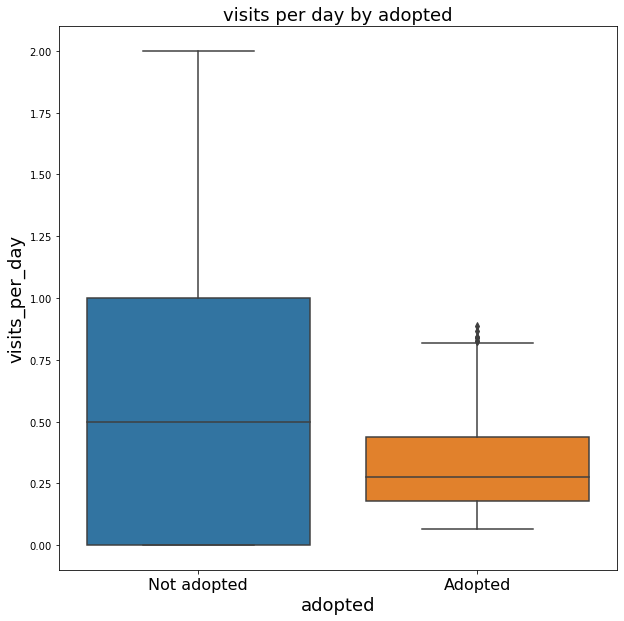

In [10]:

sns.boxplot(x='adopted', y='visits_per_day', data=us)
#plt.ylim([0,23])
plt.xlabel('adopted',fontsize=18)
plt.ylabel('visits_per_day', fontsize=18)
plt.title('visits per day by adopted',fontsize=18)
plt.xticks(ticks=[0,1],labels=['Not adopted','Adopted'],fontsize=16)
#plt.yticks(ticks=[5,10,15,20],labels=[5,10,15,20],fontsize=16)
plt.show()


We see that the median visits per day for 'not adopted' is 0.5, so apparently users who do not adopt the product either vist zero or one time.  This is corroborated by the bimodal distribution in the pairplot below.  But using this in the model would be data leakage.

In [11]:
us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int64         
 10  adopted                     12000 non-null  bool          
 11  creation_to_last            12000 non-null  int64     

In [12]:
us[us['adopted']].shape[0]

1606

In [13]:
adopted_ratio = us[us['adopted']].shape[0]/us.shape[0]

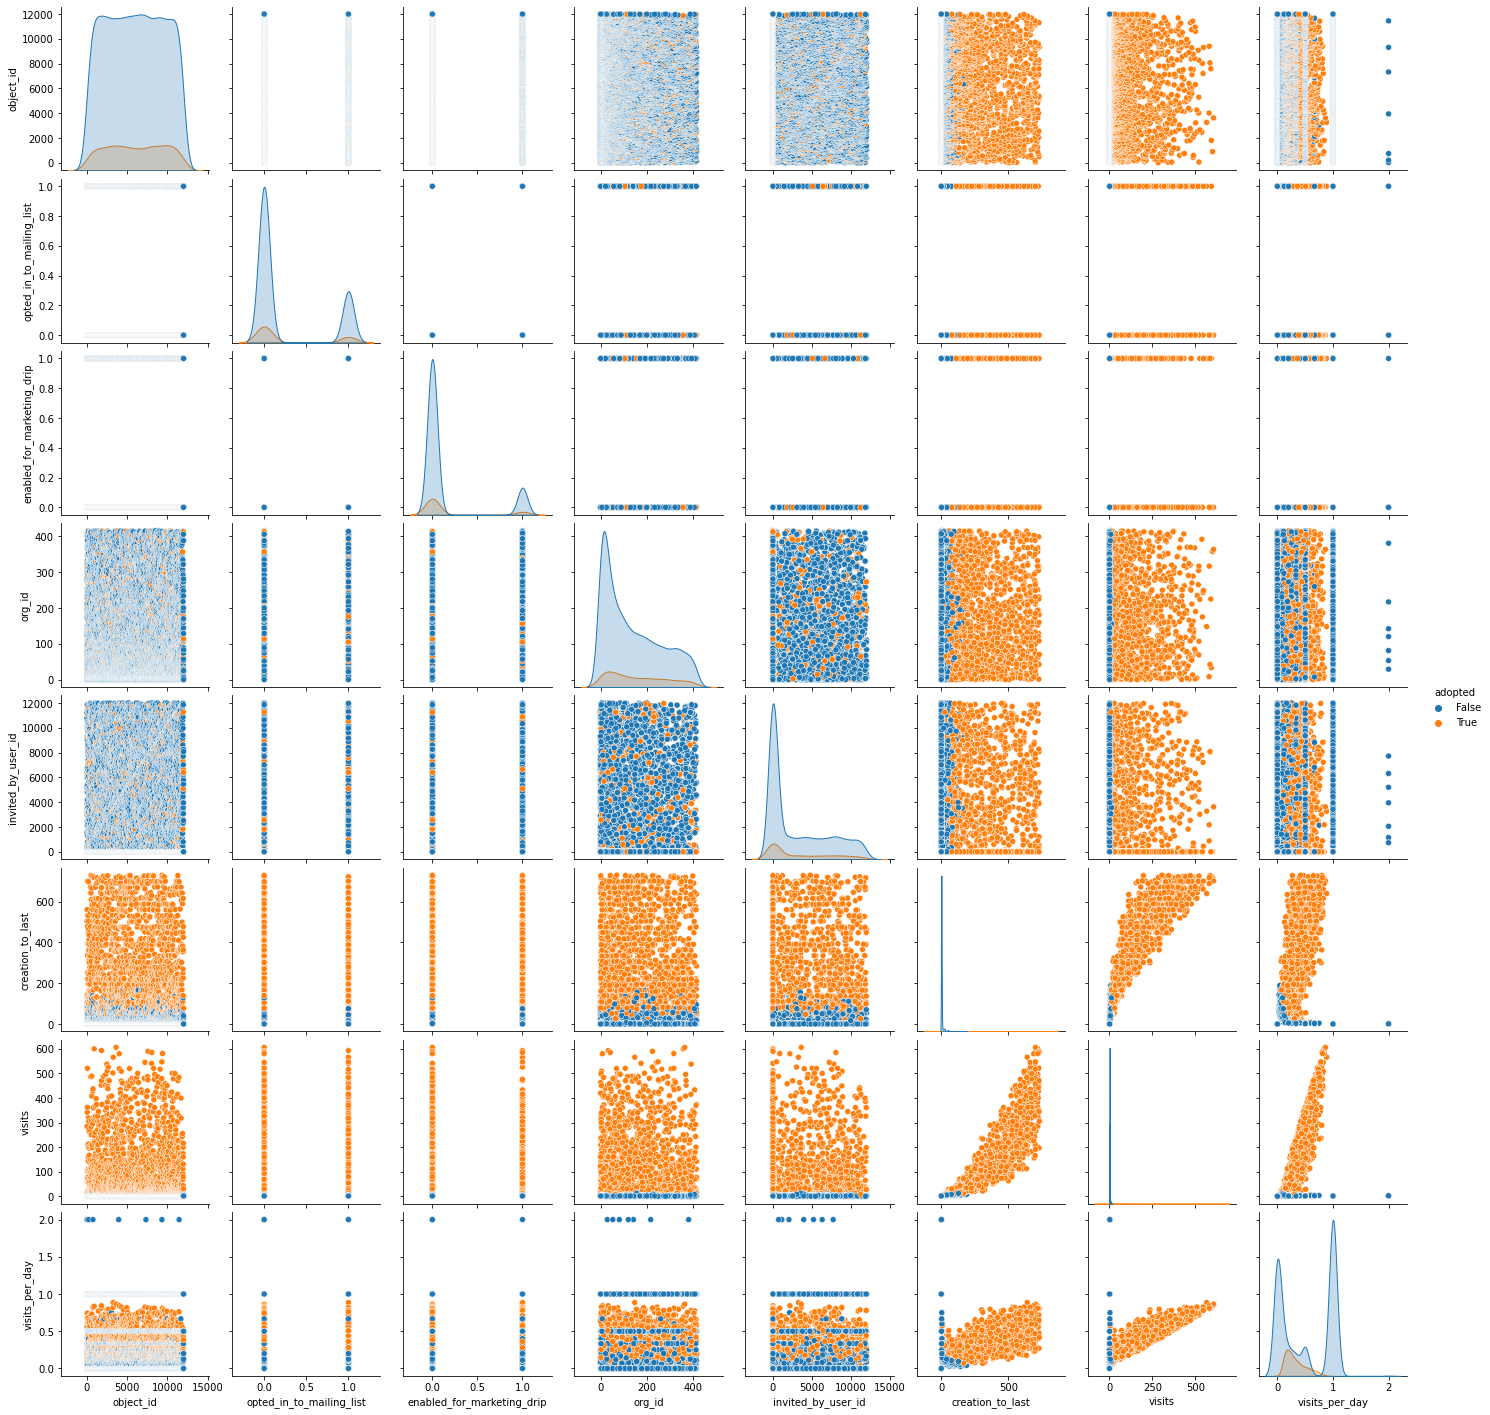

In [14]:
sns.pairplot(data=us, hue='adopted')
plt.show()

In [15]:
us['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

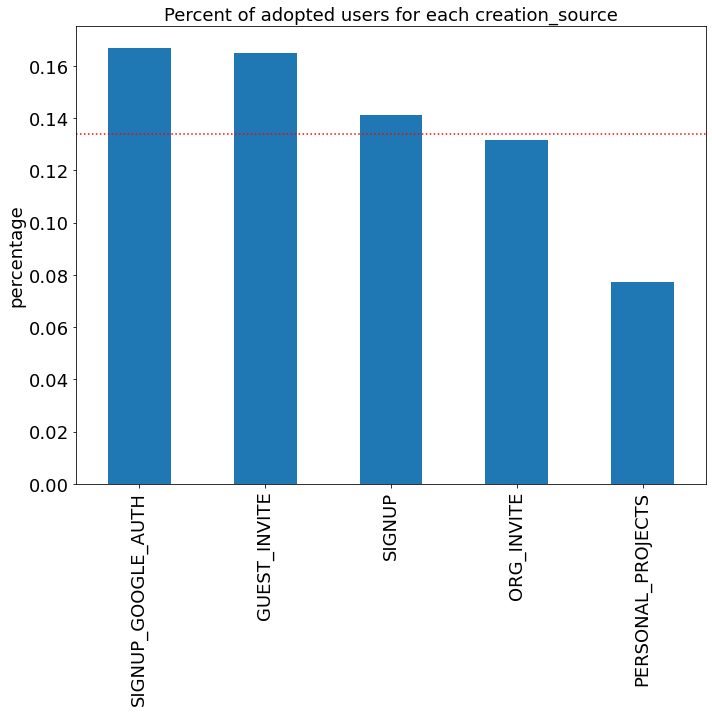

In [16]:
# percentage of adopted users for each creation_source compared to overall average


def percentage(cs):
    t = us[(us['adopted']==True)&(us['creation_source']==cs)].shape[0]
    total = us[us['creation_source']==cs].shape[0]
    return t/total

cs_rate = {cs:percentage(cs) for cs in us['creation_source'].unique()}
cs_rate = dict(sorted(cs_rate.items(), key=lambda item: item[1], reverse=True))

pd.DataFrame(cs_rate, index = [0]).transpose().plot.bar(legend=None, fontsize=18)
plt.hlines(y = adopted_ratio, color='r', xmin=-.5,xmax=4.5, ls='dotted')
plt.ylabel('percentage', fontsize=18)
plt.title('Percent of adopted users for each creation_source', fontsize=18)
plt.tight_layout()
plt.savefig('creation_source_barchart.jpeg')
plt.show()

The `creation_source` seems to indicate some relation to adoption.

## 3. VIF analysis for feature importance<a id='3.'></a>

In [17]:
def vif_analysis():
    df = us.drop(['visits','visits_per_day','object_id','name','email','creation_time','last_session_creation_time',
                 'creation_to_last'],axis=1).copy()


    df = pd.get_dummies(df)
    #gather features
    features = "+".join(df.columns[1:])

    # get y and X dataframes based on this regression:
    y_vif, X_vif = dmatrices('adopted' + ' ~' + features, df, return_type='dataframe')
    X_vif = add_constant(X_vif)

    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif["features"] = X_vif.columns


    y_log = df['adopted'].apply(int)
    X_log = add_constant(df.drop('adopted',axis=1))

    X_train, X_test, y_train, y_test = train_test_split(X_log,y_log, stratify=y_log, random_state=2)

    logit_model = Logit(y_train,X_train)
    logit_result = logit_model.fit(maxiter=40)
    summary = logit_result.summary()
    results_as_html = summary.tables[1].as_html()
    logit_res = pd.read_html(results_as_html, header=0, index_col=0)[0] 
          
    return logit_res



In [18]:
vif = vif_analysis()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


Optimization terminated successfully.
         Current function value: 0.387152
         Iterations 6


In [19]:
vif.sort_values('coef',ascending=False)

,coef,std err,z,P>|z|,[0.025,0.975]
enabled_for_marketing_drip,0.014000,0.100000,0.140,0.889,-0.182000,0.210000
org_id,0.001600,0.000000,6.718,0.000,0.001000,0.002000
invited_by_user_id,-0.000002,0.000012,-0.155,0.877,-0.000026,0.000022
opted_in_to_mailing_list,-0.016400,0.083000,-0.198,0.843,-0.178000,0.146000
creation_source_GUEST_INVITE,-0.078800,NaN,NaN,NaN,NaN,NaN
creation_source_SIGNUP_GOOGLE_AUTH,-0.106700,NaN,NaN,NaN,NaN,NaN
creation_source_SIGNUP,-0.258900,NaN,NaN,NaN,NaN,NaN
creation_source_ORG_INVITE,-0.364400,NaN,NaN,NaN,NaN,NaN
creation_source_PERSONAL_PROJECTS,-0.956500,NaN,NaN,NaN,NaN,NaN
const,-1.765300,NaN,NaN,NaN,NaN,NaN


We see from our VIF analysis that the most positively influential feature is `enabled_for_marketing_drip` followed by `org_id`.  The most negatively influential feature is `creation_source_PERSONAL_PROJECTS`.